In [1]:
import os
import sys
import pygsheets
import math
import numpy as np
import pandas as pd
import ams_utilities as au
from openpyxl import load_workbook
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from itertools import cycle
import scipy
%matplotlib notebook
import pyabf
import paq2py
import scipy.interpolate
import matplotlib.pyplot as plt
import scipy.stats as ss 
from itertools import product

In [15]:
import pygsheets
from morph_analysis_jake import *
directory = r"\\163.1.248.177\Root\jswann\Morphologies"

In [16]:
#list datapath sheets
datapaths = []
for root, subdirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith(".xlsx"):
            temppath=os.path.join(root, filename)
            datapaths.append(temppath)
print(len(datapaths))

59


In [17]:
#create dataframe
df_all = {}
for i in datapaths:

    df_single_cell = make_param_df(i)

    if i == datapaths[0]:
        df_all = df_single_cell

    else:

        df_all = pd.concat([df_all, df_single_cell], axis=1, join='outer', join_axes=None, ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, sort=None, copy=True)

#Sort columns into order
df_all=df_all.reindex(sorted(df_all.columns),axis=1)

In [18]:
df_all.head()

,AS016: Cell01,AS016: Cell02,AS029: Cell01,AS030: Cell01,AS035: Cell01,AS036: Cell01,AS038: Cell01,AS039: Cell01,AS039: Cell02,AS040: Cell01,...,AS114: Cell01,AS114: Cell02,AS114: Cell03,AS115: Cell01,AS116: Cell01,AS116: Cell02,AS117: Cell04,AS132: Cell03,AS143: Cell03,AS152: Cell01
Axon_node_total,6.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,5.000000,6.000000,6.000000,0.000000
Axon_length,1620.490000,0.0,28.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,118.660000,0.0,0.0,0.0,0.0,0.0,355.680000,1137.770000,629.870000,123.850000
Axon_SA,10859.800000,0.0,104.620000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,454.330000,0.0,0.0,0.0,0.0,0.0,981.420000,5585.990000,2131.560000,189.150000
Axon_length_to_SA_ratio,0.149219,NaN,0.271459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.261176,NaN,NaN,NaN,NaN,NaN,0.362414,0.203683,0.295497,0.654771
Highest_order_axon_segment,4.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,4.000000,7.000000,7.000000,1.000000


In [19]:
#add slice orientations
if 'Slice_Orientation' not in df_all.index:
    text_file=open('E:\\Jake\\Orientations.txt')
    orientations=list(text_file.read())
    orientations=pd.Series(orientations).to_frame().T
    orientations.index=['Slice_Orientation']
    orientations.columns=df_all.columns
    df_all=pd.concat([orientations,df_all], join='inner')

In [20]:
df_all.head()

,AS016: Cell01,AS016: Cell02,AS029: Cell01,AS030: Cell01,AS035: Cell01,AS036: Cell01,AS038: Cell01,AS039: Cell01,AS039: Cell02,AS040: Cell01,...,AS114: Cell01,AS114: Cell02,AS114: Cell03,AS115: Cell01,AS116: Cell01,AS116: Cell02,AS117: Cell04,AS132: Cell03,AS143: Cell03,AS152: Cell01
Slice_Orientation,H,H,H,H,H,C,H,H,H,H,...,C,C,C,C,C,C,C,C,C,C
Axon_node_total,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,6,6,0
Axon_length,1620.49,0,28.4,0,0,0,0,0,0,0,...,118.66,0,0,0,0,0,355.68,1137.77,629.87,123.85
Axon_SA,10859.8,0,104.62,0,0,0,0,0,0,0,...,454.33,0,0,0,0,0,981.42,5585.99,2131.56,189.15
Axon_length_to_SA_ratio,0.149219,NaN,0.271459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.261176,NaN,NaN,NaN,NaN,NaN,0.362414,0.203683,0.295497,0.654771


In [21]:
#Add polar analysis data
if 'Dendrite_polar_length_mean' not in df_all.index:
    df_polar=pd.read_excel('E:\\Jake\\2020-05-31_Morphologies_PolarMetrics.xlsx', indexCol=0)
    df_polar=df_polar.drop(['Unnamed: 0'],axis=1)
    variableNames=['Dendrite_polar_length_mean', 
             'Dendrite_polar_length_std',
             'Dendrite_polar_length_variance',
             'Dendrite_polar_longest_bin']
    df_polar.index=variableNames
    df_all=pd.concat([df_all,df_polar], join='inner') #This will drop any cells with no dendritic data
df_polar.T

,Dendrite_polar_length_mean,Dendrite_polar_length_std,Dendrite_polar_length_variance,Dendrite_polar_longest_bin
AS016: Cell01,0.398822,0.211449,0.044711,260.0
AS016: Cell02,0.371481,0.236290,0.055833,140.0
AS029: Cell01,0.374605,0.300087,0.090052,340.0
AS030: Cell01,0.327464,0.236692,0.056023,100.0
AS035: Cell01,0.321695,0.279975,0.078386,340.0
AS036: Cell01,0.349470,0.310290,0.096280,260.0
AS038: Cell01,0.459234,0.181563,0.032965,100.0
AS039: Cell01,0.379131,0.255947,0.065509,340.0
AS039: Cell02,0.638801,0.186113,0.034638,300.0
AS040: Cell01,0.390497,0.241370,0.058259,340.0


In [22]:
#export to google sheet
creds = r"C:\Users\Packer Lab\Documents\Python Scripts\Code\creds_jake.json"
gc = pygsheets.authorize(service_file=creds)

df = pd.DataFrame()

params = list(df_all.index.values)
df['Parameters'] = params
df.columns = ['Mouse#: Cell']

sh = gc.open('Morph_analysis')

wks = sh[0]
wks.set_dataframe(df, (1,1))
wks.set_dataframe(df_all, (1,2))


In [23]:
from ams_paq_utilities import *
from ams_utilities import *
import scipy
%matplotlib notebook
import pyabf
import paq2py
import scipy.interpolate
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import scipy.stats as ss 
from itertools import product

# Eliminate rows containing redundant, uninformative or incomplete (NaN) data
# In this instance -- will focus on dendritic data and soma perimeter, drop everything ele 
dattab = df_all.iloc[25:66,:]
dattab = dattab.drop(['Soma_surace_area',
                     'Soma_volume',
                     'Soma_aspect_ration',
                     'Soma_compactness_factor',
                     'Soma_form_factor',
                     'Somatic_roundness',
                     'Dendrite_max_extent'],0)
#Drop cells that we've decided are bad
dattab=dattab.drop(['AS035: Cell01',
                    'AS057: Cell03',
                    'AS062: Cell03',
                    'AS063: Cell03',
                    'AS091: Cell03',
                    'AS132: Cell03',
                    'AS143: Cell03',
#8 outliers
#                     'AS039: Cell02',
#                     'AS040: Cell01',
#                     'AS152: Cell01',
#                     'AS062: Cell02',
#                     'AS059: Cell02',
#                     'AS117: Cell04',
#                     'AS115: Cell01',
#                     'AS071: Cell01'
                    ], 1)

# Convert to float array and standardise data ((x - mean)/std)
dattab = au.str_flt(dattab.iloc[:,:])
dattab -= np.mean(dattab)
dattab /= np.std(dattab)

# # Transpose array so variables arranged column-wise 
data = dattab.T

# data.columns.names = ["metric"]
# data.index.names = ["cell"]
data

,Dendrite_node_total,Total_dendrite_length,Average_dendrite_length,Dendrite_SA,Dendrite_length_to_SA_ratio,Highest_order_dendrite_segment,Dendrite_polar_angle,Dendrite_polar_angle_std,Dendrite_local_angle,Dendrite_local_angle_std,...,Dendrite_sholl_number_10,Dendrite_sholl_number_50,Dendrite_sholl_number_100,Dendrite_sholl_number_200,Dendrite_sholl_number_300,Soma_perimeter,Dendrite_polar_length_mean,Dendrite_polar_length_std,Dendrite_polar_length_variance,Dendrite_polar_longest_bin
AS016: Cell01,-0.202647,0.636172,-0.041362,5.684162,-0.210721,-0.208161,-0.203042,-0.205027,-0.201112,-0.205604,...,-0.209195,-0.207644,-0.208850,-0.209367,-0.209712,-0.191617,-0.210677,-0.210709,-0.210738,-0.165944
AS016: Cell02,-0.226565,0.957708,-0.038543,5.616729,-0.237658,-0.231849,-0.199083,-0.206827,-0.192223,-0.212902,...,-0.231849,-0.226565,-0.236472,-0.237793,-0.237793,-0.200588,-0.237548,-0.237637,-0.237756,-0.145325
AS029: Cell01,-0.261996,1.542647,0.027142,5.447481,-0.275553,-0.267072,-0.208417,-0.225447,-0.191792,-0.218663,...,-0.267072,-0.260727,-0.269611,-0.275956,-0.275956,-0.213085,-0.275481,-0.275575,-0.275842,0.155537
AS030: Cell01,-0.203744,0.686427,-0.129893,5.678638,-0.211473,-0.208142,-0.191341,-0.196666,-0.187956,-0.198742,...,-0.207465,-0.207127,-0.209833,-0.210171,-0.211186,-0.186307,-0.211413,-0.211444,-0.211505,-0.177699
AS036: Cell01,-0.215567,0.786429,0.031344,5.658022,-0.220301,-0.216411,-0.202121,-0.208062,-0.201966,-0.207415,...,-0.218943,-0.218662,-0.218662,-0.218099,-0.219506,-0.207514,-0.220251,-0.220262,-0.220322,-0.147212
AS038: Cell01,-0.219855,0.925295,0.059213,5.628356,-0.229409,-0.226149,-0.208191,-0.216014,-0.202058,-0.214356,...,-0.226890,-0.223928,-0.225039,-0.229111,-0.229482,-0.203694,-0.229312,-0.229414,-0.229469,-0.192457
AS039: Cell01,-0.199690,0.611243,-0.007703,5.685798,-0.213987,-0.211451,-0.201584,-0.204586,-0.200881,-0.204809,...,-0.212521,-0.210168,-0.209527,-0.213804,-0.214017,-0.189407,-0.213936,-0.213963,-0.214003,-0.141313
AS039: Cell02,-0.174132,1.645911,-0.011339,5.361839,-0.287166,-0.267911,-0.218832,-0.250150,-0.213447,-0.249503,...,-0.255916,-0.286449,-0.287540,-0.287540,-0.287540,-0.240334,-0.286843,-0.287337,-0.287502,0.039597
AS040: Cell01,-0.240161,1.921193,0.132085,5.212481,-0.314528,-0.292353,-0.219746,-0.243306,-0.197851,-0.245331,...,-0.280936,-0.307033,-0.315188,-0.315188,-0.315188,-0.252443,-0.314551,-0.314794,-0.315093,0.239357
AS045: Cell01,-0.222678,0.925300,-0.104040,5.625128,-0.232621,-0.230091,-0.205975,-0.217780,-0.201147,-0.217042,...,-0.228347,-0.222242,-0.228783,-0.232707,-0.232707,-0.175941,-0.232502,-0.232605,-0.232683,-0.119340


<IPython.core.display.Javascript object>


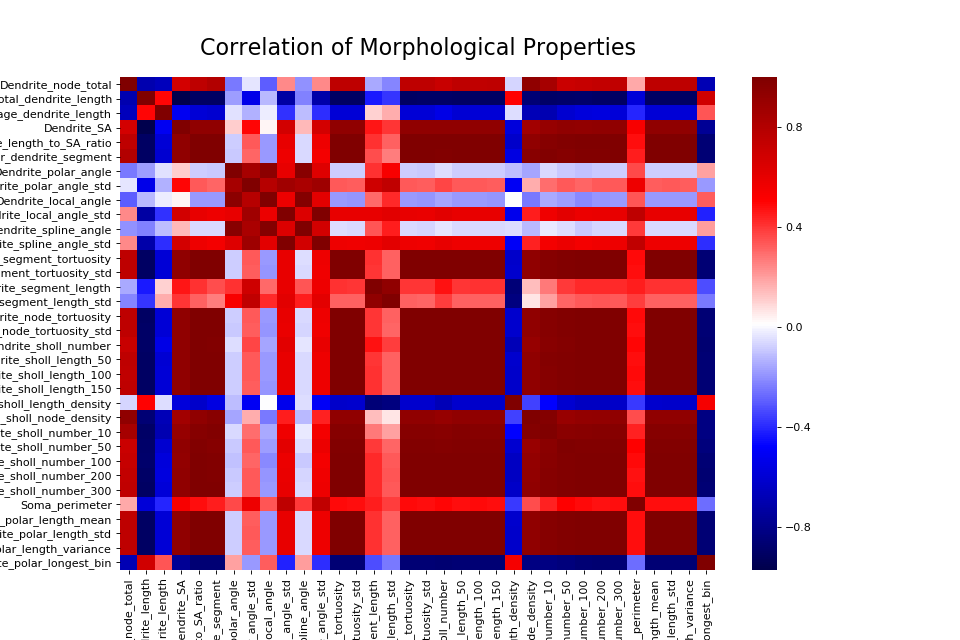

In [24]:
plt.figure(figsize=(12,8))
plt.title('Correlation of Morphological Properties', fontsize=20, y = 1.03);
dattabcor = dattab.T
cor = dattabcor.corr()
# cor = dattab.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.seismic)
plt.show()

In [25]:
# Perform PCA 
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(data)
pcList=['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5','principal component 6', 'principal component 7', 'principal component 8', 'principal component 9', 'principal component 10']

principalDf = pd.DataFrame(data=principalComponents, columns = pcList)
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-0.608036,0.029409,-0.028647,0.047655,-0.027717,0.033664,0.009940,-0.000706,-0.002082,0.000343
1,-0.220089,-0.137859,-0.034471,-0.045895,0.030761,-0.009868,-0.002695,0.012160,-0.007992,-0.000626
2,0.448345,-0.085160,0.027742,0.149481,-0.014254,-0.028354,-0.002850,0.012671,-0.003694,-0.013467
3,-0.586824,-0.014483,0.055661,0.073632,0.004672,0.033702,0.012612,-0.003508,-0.001184,-0.000544
4,-0.448357,0.101271,-0.018027,0.040655,-0.020577,0.014254,0.017253,0.005135,-0.003621,-0.003857
5,-0.289224,0.045995,-0.016087,-0.059674,0.004374,0.001667,0.003110,0.005333,-0.002892,-0.001295
6,-0.606618,0.023049,-0.086123,0.047392,-0.033652,0.032390,0.008080,-0.007984,0.000033,0.000750
7,0.655984,-0.478008,-0.075966,-0.160667,-0.013308,0.013636,0.035169,-0.001811,0.037048,-0.002036
8,1.066604,-0.473631,-0.203499,-0.090687,-0.018966,0.042141,0.018453,0.003407,-0.018114,-0.000616
9,-0.263732,-0.180916,-0.007488,-0.003271,0.006481,-0.004991,-0.022699,0.012270,0.003888,0.006095


In [26]:
# SANITY CHECK - do values correlate as expected
def corrank(X):
        import itertools
        df = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
        print(df.sort_values(by='corr',ascending=False))

print ('Top Correlations')
corrank(data)

Top Correlations
                                                 pairs      corr
558  (Dendrite_polar_length_std, Dendrite_polar_len...  0.999999
493  (Dendrite_sholl_length_150, Dendrite_polar_len...  0.999998
153  (Dendrite_length_to_SA_ratio, Dendrite_polar_l...  0.999997
152  (Dendrite_length_to_SA_ratio, Dendrite_polar_l...  0.999997
142  (Dendrite_length_to_SA_ratio, Dendrite_sholl_l...  0.999996
492  (Dendrite_sholl_length_150, Dendrite_polar_len...  0.999996
151  (Dendrite_length_to_SA_ratio, Dendrite_polar_l...  0.999995
556  (Dendrite_polar_length_mean, Dendrite_polar_le...  0.999994
480  (Dendrite_sholl_length_100, Dendrite_polar_len...  0.999994
555  (Dendrite_polar_length_mean, Dendrite_polar_le...  0.999993
481  (Dendrite_sholl_length_100, Dendrite_polar_len...  0.999993
141  (Dendrite_length_to_SA_ratio, Dendrite_sholl_l...  0.999992
470  (Dendrite_sholl_length_100, Dendrite_sholl_len...  0.999992
491  (Dendrite_sholl_length_150, Dendrite_polar_len...  0.999991
369  (De

<IPython.core.display.Javascript object>


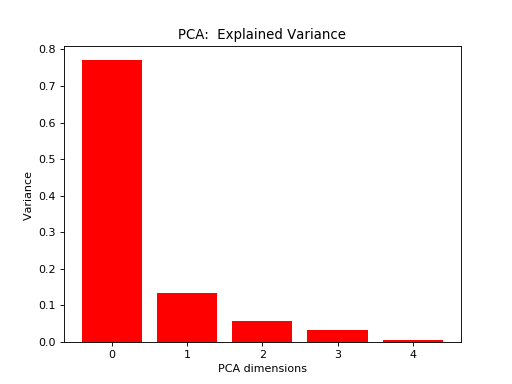

Text(0.5, 1.0, 'PCA:  Explained Variance')

In [27]:
# # Perform PCA (assuming no of appropriate factors has already been determined)
pca = PCA(n_components = 5).fit(data)
X_pca = pca.transform(data)
PCA_components = pd.DataFrame(X_pca)
plt.subplots()
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='red')
plt.xlabel('PCA dimensions')
plt.ylabel('Variance ')
plt.title('PCA:  Explained Variance')


In [28]:
print(pca.explained_variance_)

[0.1774 0.0307 0.0128 0.0075 0.001 ]


In [29]:
loadings=pd.DataFrame(pca.components_, columns = data.columns, index = ['PC1','PC2','PC3','PC4','PC5'])


<IPython.core.display.Javascript object>


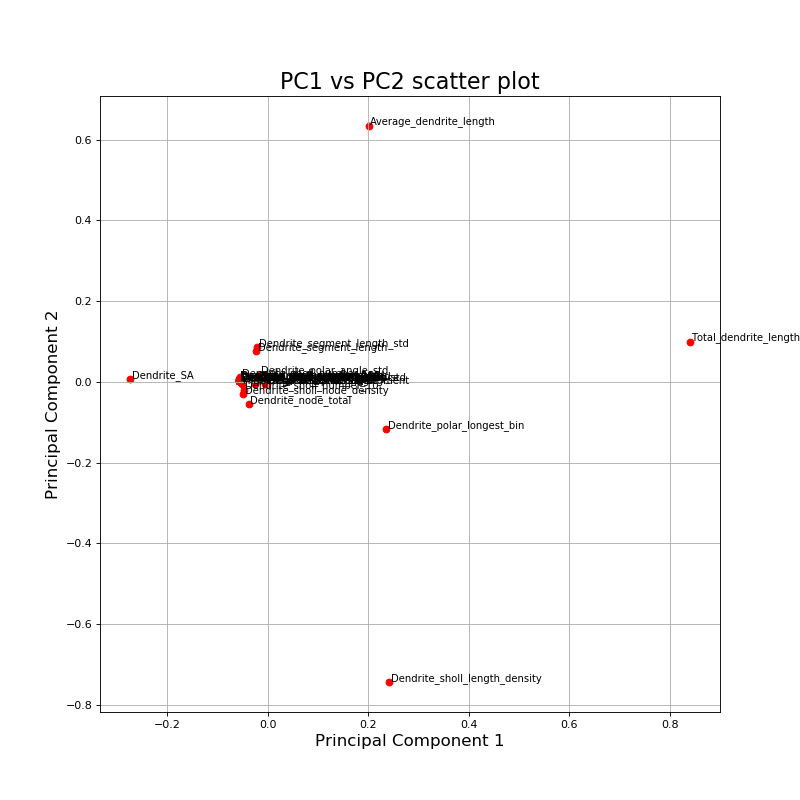

In [30]:
#PC1 & PC2 scatter plot
# plt.figure()
# labels = loadings.index 
# sns.scatterplot(x='PC1', y='PC2', data=loadings.iloc[:,[0,1]])
# plt.show()

PC1 = loadings.values[0]
PC2 = loadings.values[1]
labels = loadings.columns 

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(PC1,PC2, color='red')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PC1 vs PC2 scatter plot', fontsize = 20)
ax.grid()

for i,type in enumerate(labels):
    
    x = PC1[i]
    y = PC2[i]
    plt.text(x+0.003, y+0.003, type, fontsize=9)
    
    
plt.show()

In [31]:
loadings.values[:,0]

array([-0.0376, -0.0546,  0.0261, -0.0903, -0.1589])

<IPython.core.display.Javascript object>


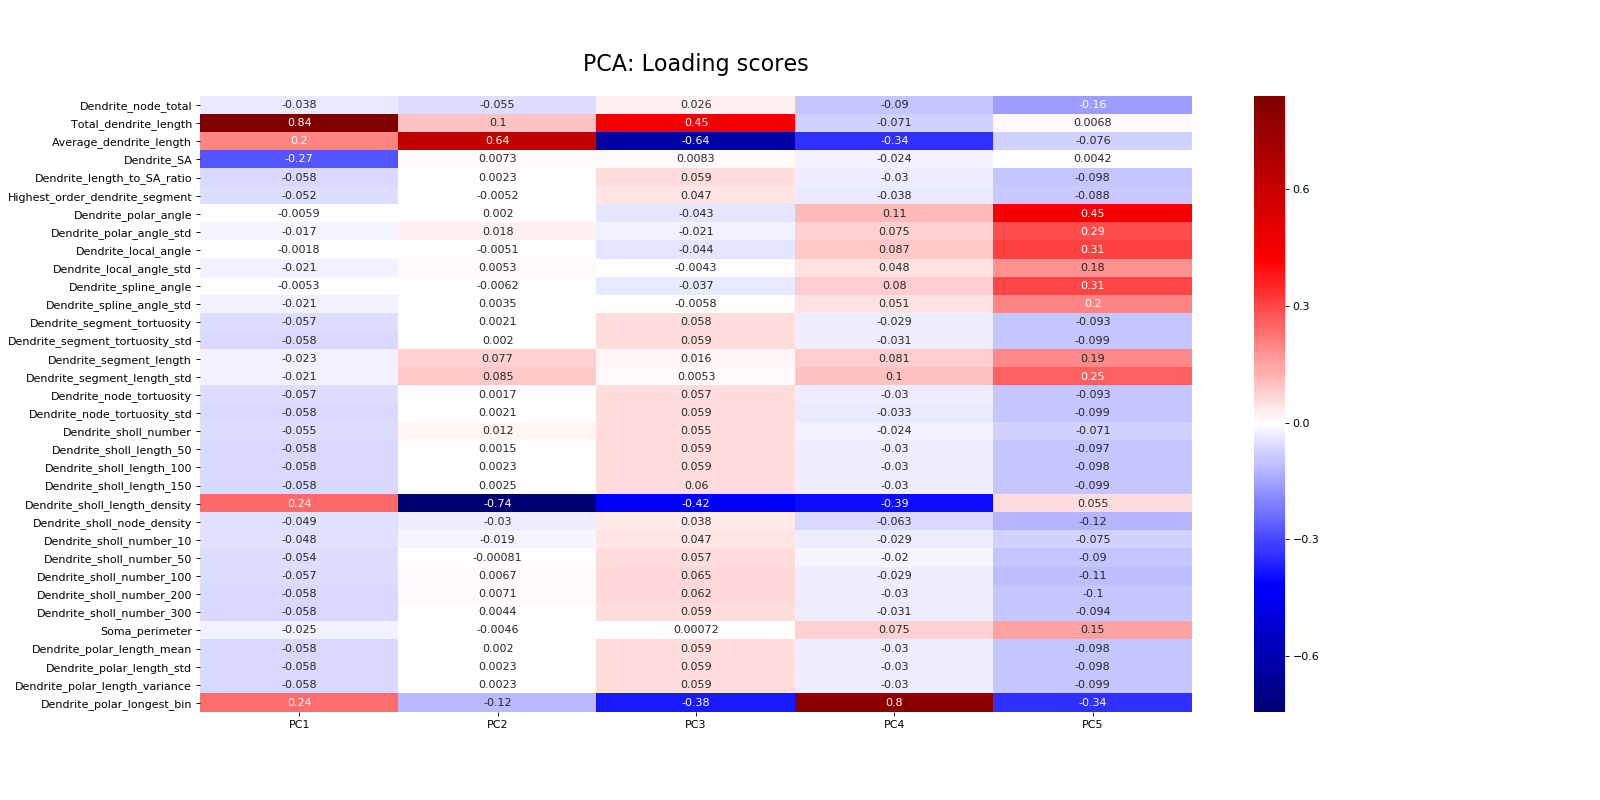

In [32]:
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.title('PCA: Loading scores', fontsize=20, y = 1.03)
sns.heatmap(loadings.T, annot=True, cmap=plt.cm.seismic, center=0)
plt.savefig('E:\Jake\PCA_loading_scores.png')
plt.show()


<IPython.core.display.Javascript object>


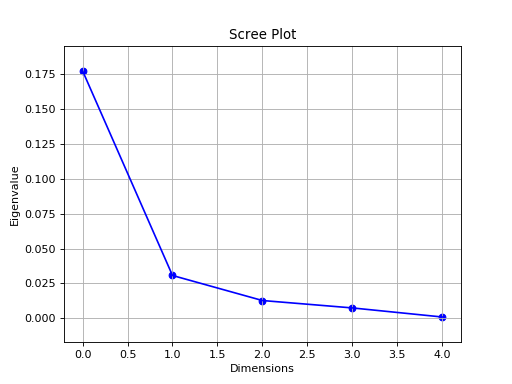

In [33]:
plt.subplots()
plt.scatter(features, pca.explained_variance_, color = 'blue')
plt.plot(features, pca.explained_variance_, color = 'blue')
plt.title('Scree Plot')
plt.xlabel('Dimensions')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


<IPython.core.display.Javascript object>


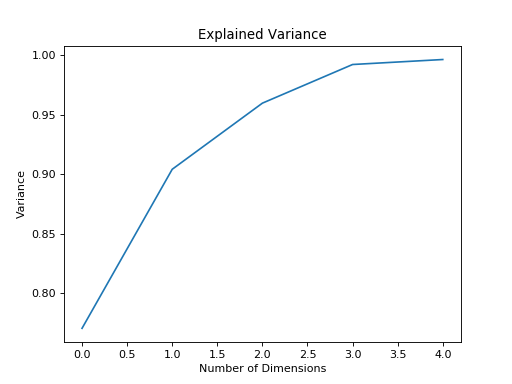

array([0.7706, 0.1334, 0.0555, 0.0324, 0.0042])

In [34]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Dimensions')
plt.ylabel('Variance') #for each component
plt.title('Explained Variance')
plt.show()

display(pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>


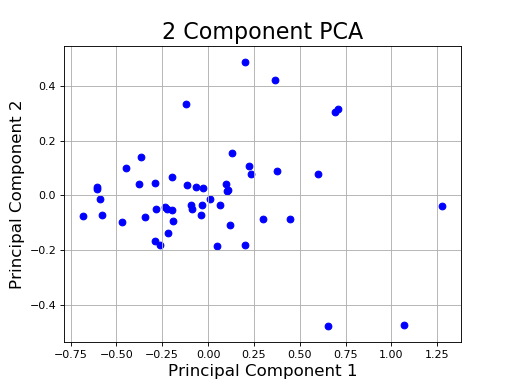

In [35]:
# Create plot of PC space (components 1/2)
fig, ax = plt.subplots()
plt.scatter(PCA_components[0], PCA_components[1], color='blue')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.grid()

In [36]:
# Re run PCA on appropraite number of components 
pca = PCA(n_components=3)
pca.fit_transform(data)


array([[-0.608 ,  0.0294, -0.0286],
       [-0.2201, -0.1379, -0.0345],
       [ 0.4483, -0.0852,  0.0277],
       ...,
       [ 0.1186, -0.108 ,  0.1074],
       [-0.1197,  0.3334, -0.1983],
       [ 1.2745, -0.0394,  0.0629]])

<IPython.core.display.Javascript object>


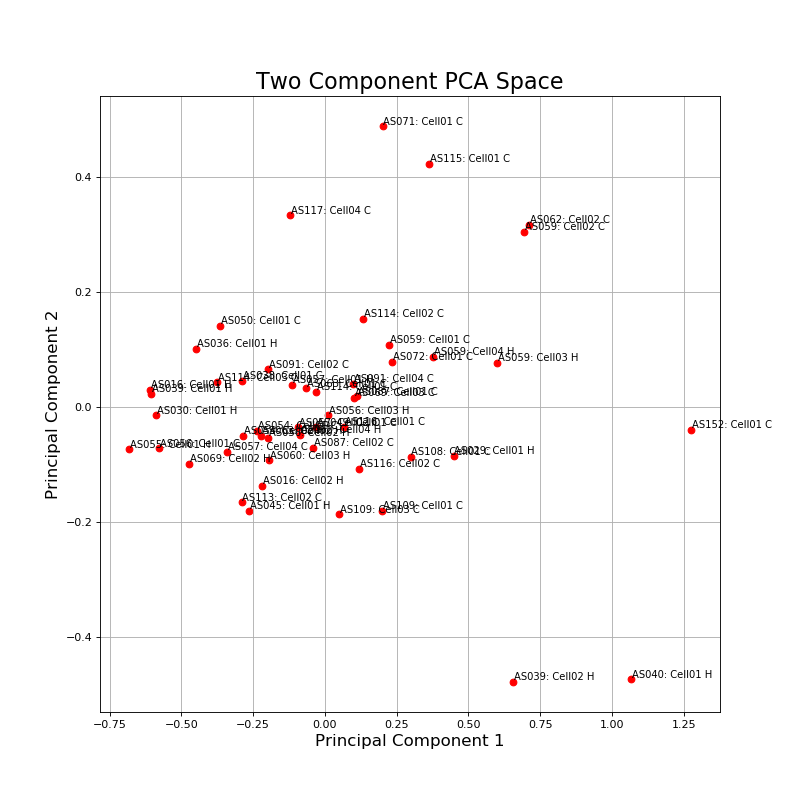

In [37]:
# Create plot of PC space (components 1/2)

P1 = PCA_components[0]
P2 = PCA_components[1]
labs=[]
for i in range(0,len(data.index)):
    labs.append(data.index[i]+' '+str(df_all.iloc[0,i]))
labels = labs


fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(P1,P2, color='red')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two Component PCA Space', fontsize = 20)
ax.grid()

for i,type in enumerate(labels):
    
    x = P1[i]
    y = P2[i]
    plt.text(x+0.003, y+0.003, type, fontsize=9)
    
    
plt.show()

P1morph=P1
P2morph=P2

In [38]:
x = np.array(PCA_components[0])
y = np.array(PCA_components[1])
z = np.array(PCA_components[2])
# w = np.array(PCA_components[3])
# u = np.array(PCA_components[4])


X = np.column_stack((x,y,z))

#For k-means without PCA
# X=np.array(data)

<IPython.core.display.Javascript object>


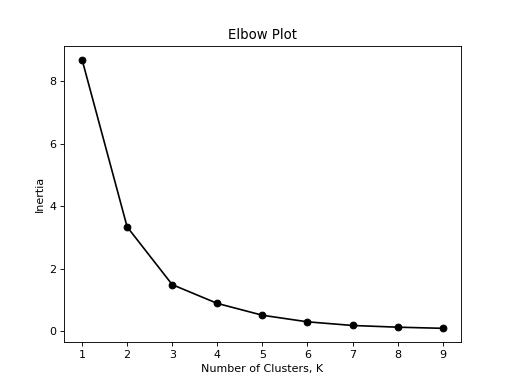

In [39]:
# You can assess appropriate number of clusters by identifying 'elbow' in KMeans Inertia plot 

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,0:1])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
fig, ax = plt.subplots()
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Number of Clusters, K')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.xticks(ks)
plt.show()

#For k-means without PCA
# ks = range(1, 10)
# inertias = []
# for k in ks:
#     # Create a KMeans instance with k clusters
#     model = KMeans(n_clusters=k)
    
#     # Fit model to samples
#     model.fit(data)
    
#     # Append the inertia to the list of inertias
#     inertias.append(model.inertia_)
    
# fig, ax = plt.subplots()
# plt.plot(ks, inertias, '-o', color='black')
# plt.xlabel('Number of Clusters, K')
# plt.ylabel('Inertia')
# plt.title('Elbow Plot')
# plt.xticks(ks)
# plt.show()

<IPython.core.display.Javascript object>


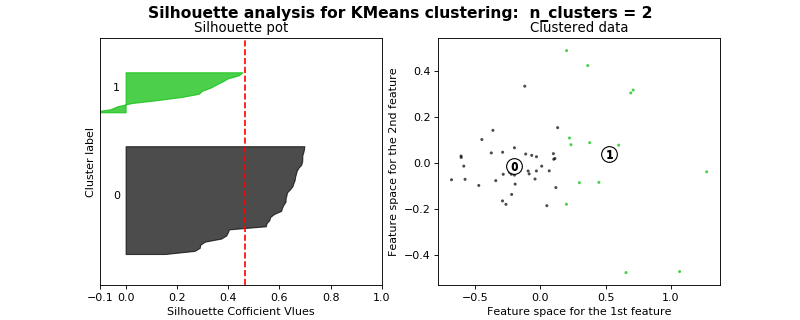

For n_clusters = 2 The average silhouette_score is : 0.46436299365084044


<IPython.core.display.Javascript object>


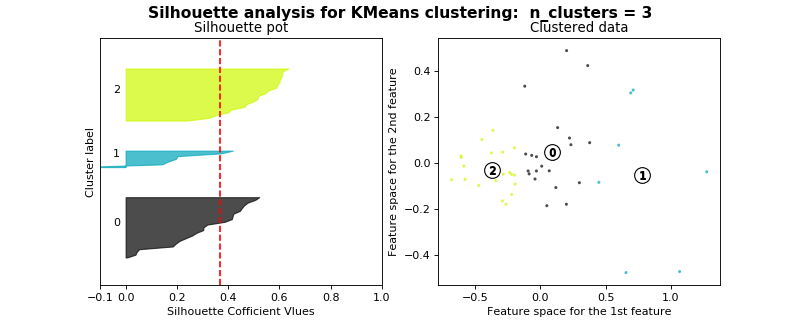

For n_clusters = 3 The average silhouette_score is : 0.36793319091098664


<IPython.core.display.Javascript object>


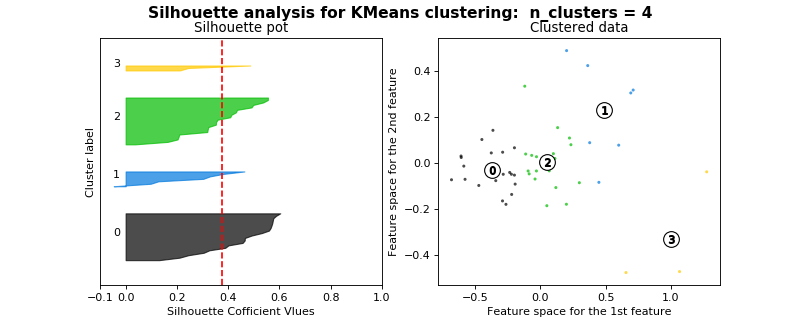

For n_clusters = 4 The average silhouette_score is : 0.3759163465100031


<IPython.core.display.Javascript object>


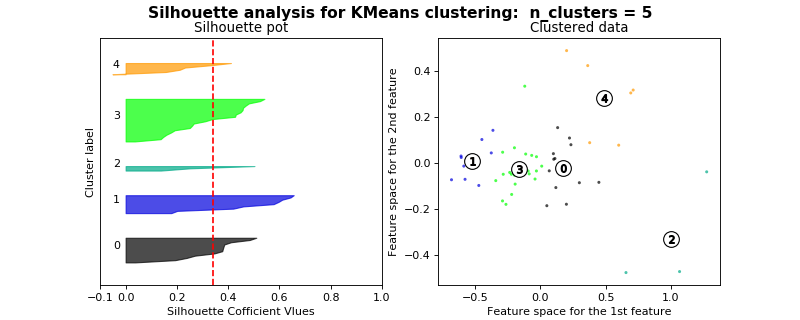

For n_clusters = 5 The average silhouette_score is : 0.3410628487559743


<IPython.core.display.Javascript object>


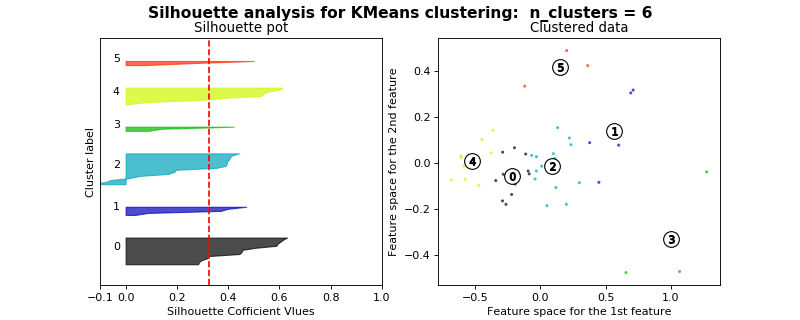

For n_clusters = 6 The average silhouette_score is : 0.32736150575926154


<IPython.core.display.Javascript object>


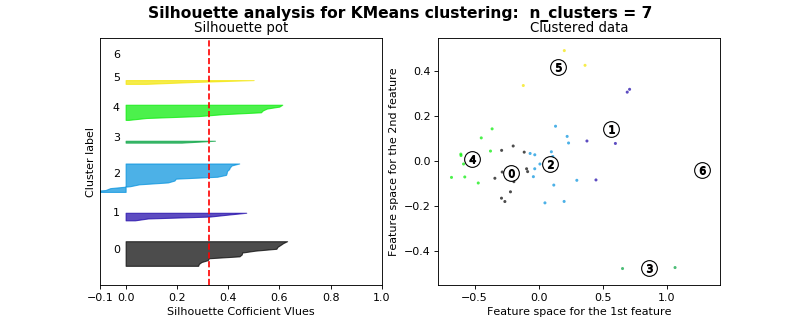

For n_clusters = 7 The average silhouette_score is : 0.32475882106545667


<IPython.core.display.Javascript object>


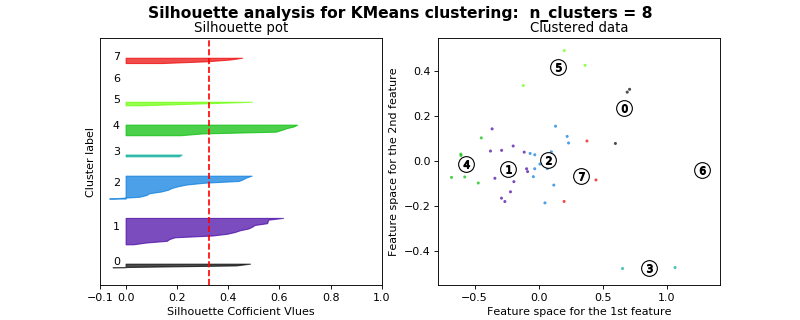

For n_clusters = 8 The average silhouette_score is : 0.32723875276490155


<IPython.core.display.Javascript object>


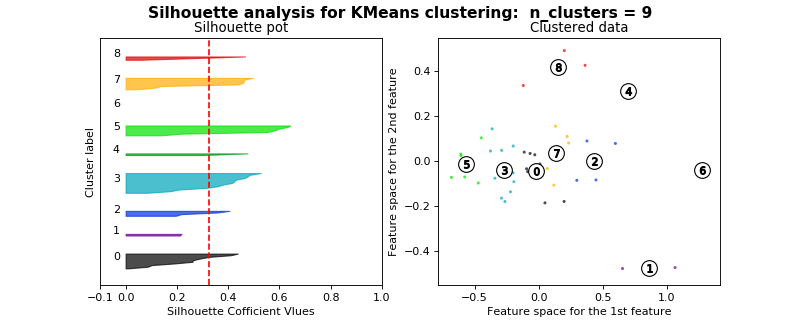

For n_clusters = 9 The average silhouette_score is : 0.3253610180388284


<IPython.core.display.Javascript object>


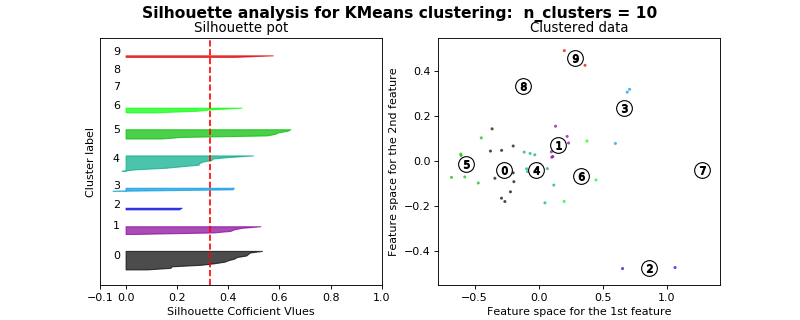

For n_clusters = 10 The average silhouette_score is : 0.3295685344055967


In [40]:
# Sihouette analysis enables you to compare results of K-means for different number of clusters
# Highest silhouette value indicates most variance explained 
clustersdf=pd.DataFrame(data=None, index=data.index)
range_n_clusters = [2, 3, 4, 5, 6, 7,8,9,10]

for n_clusters in range_n_clusters:
  
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("Silhouette pot")
    ax1.set_xlabel("Silhouette Cofficient Vlues")
    ax1.set_ylabel("Cluster label")

  
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering:  "
                  "n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

  
    clustersdf.insert(n_clusters-2, str(n_clusters), clusterer.labels_)

plt.show()
clustersdf.to_csv('E:\Jake\morphology_k-means_clusters.csv')

<IPython.core.display.Javascript object>


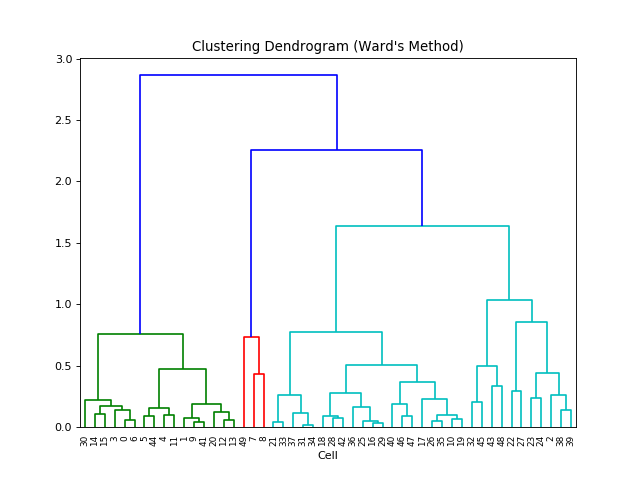

In [41]:
# Ward's method - hierarchical clustering (top down) 

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(8, 6))
plt.title("Clustering Dendrogram (Ward's Method)")
plt.xlabel("Cell")
plt
dend = shc.dendrogram(shc.linkage(X, method='ward'))

<IPython.core.display.Javascript object>


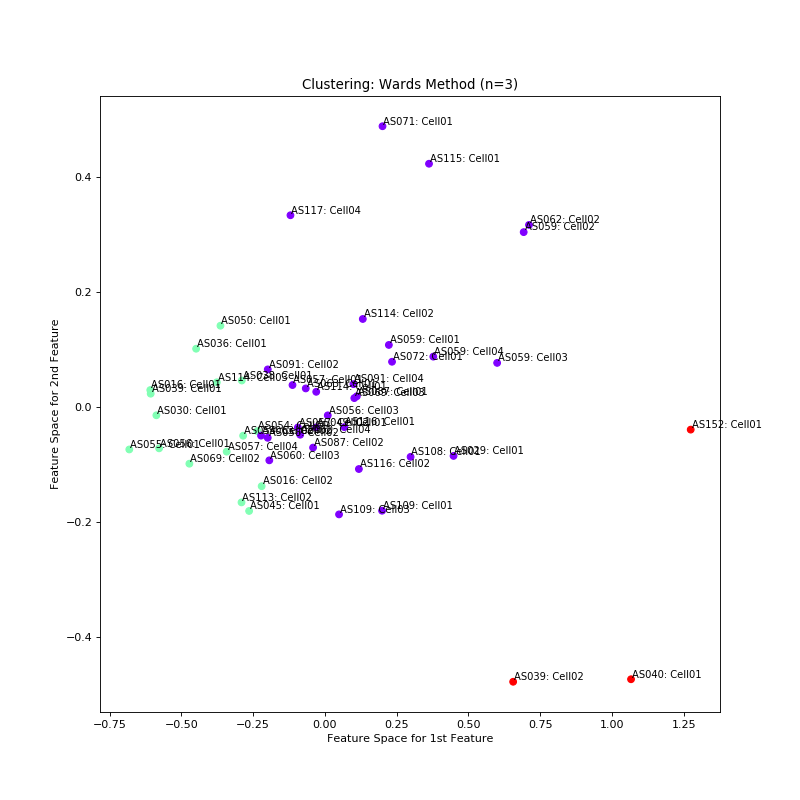

In [42]:
plt.figure(figsize=(10,10))
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')
plt.xlabel('Feature Space for 1st Feature')
plt.ylabel('Feature Space for 2nd Feature')
plt.title('Clustering: Wards Method (n=3)')

labels = data.index

P1 = X[:,0]
P2 = X[:,1]

for i,type in enumerate(labels):
    
    x = P1[i]
    y = P2[i]
    plt.text(x+0.003, y+0.003, type, fontsize=9)
    
    
plt.show()

In [43]:
df = pd.DataFrame(cluster.labels_, labels)
df.columns = ['Cluster']
df.index.name = 'Cell'

Group1 = df.loc[df['Cluster'] == 0]

Group2 = df.loc[df['Cluster'] == 1]

Group3 = df.loc[df['Cluster'] == 2]

# Group4 = df.loc[df['Cluster'] == 3]

# Group5 = df.loc[df['Cluster'] == 4]

a = pd.DataFrame(Group1.index)
b = pd.DataFrame(Group2.index)
c = pd.DataFrame(Group3.index)
# d = pd.DataFrame(Group4.index)
# e = pd.DataFrame(Group5.index)

clusters = pd.concat([a,b,c], ignore_index=True, axis=1)
clusters.columns = ['Cluster 1', 'Cluster 2', 'Cluster 3']

clusters

,Cluster 1,Cluster 2,Cluster 3
0,AS029: Cell01,AS016: Cell01,AS039: Cell02
1,AS049: Cell01,AS016: Cell02,AS040: Cell01
2,AS056: Cell02,AS030: Cell01,AS152: Cell01
3,AS056: Cell03,AS036: Cell01,NaN
4,AS057: Cell01,AS038: Cell01,NaN
5,AS057: Cell02,AS039: Cell01,NaN
6,AS059: Cell01,AS045: Cell01,NaN
7,AS059: Cell02,AS050: Cell01,NaN
8,AS059: Cell03,AS054: Cell01,NaN
9,AS059: Cell04,AS054: Cell02,NaN


Estimated number of clusters: 9


<IPython.core.display.Javascript object>


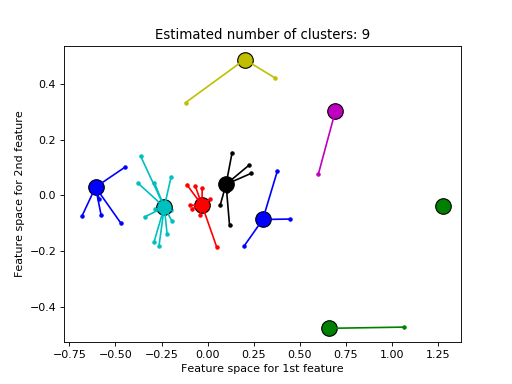

In [44]:
# Affinity Propagation 

# Perform affinity propagation 


# Need to figure out how to find optimal cluster value


af = AffinityPropagation(preference = None).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

# Plot result

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel('Feature space for 1st feature')
plt.ylabel('Feature space for 2nd feature')
plt.show()

In [45]:
#ADD EPHYS CLUSTERS
%load_ext autoreload
%autoreload 2
import sys
sys.path
from ams_paq_utilities import *
from ams_utilities import *
import scipy
import matplotlib.pyplot as plt
%matplotlib notebook
import pyabf
import paq2py
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.interpolate
import itertools
from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import scipy.stats as ss 
from itertools import product
from sklearn.cluster import AffinityPropagation
from itertools import cycle

In [46]:
# Import data from spreadsheet 
df = GS_to_df('https://docs.google.com/spreadsheets/d/1ziOx80em0ZhmMmSjKePYbOq3K6sHcOapfHjy9S4oDbk/edit#gid=1828339698')

In [47]:
# Eliminate rows containing redundant, uninformative or incomplete (NaN) data

df = df.drop([1,25,36,37], axis=0)#HOW TO DEAL WITH ISI ARRAYS,THIS WHOLE THING MIGHT NEED REDOING 
df = df.replace([np.inf, -np.inf], np.nan)
dattab = df.dropna(axis=1, how='any')
celllabels = dattab.iloc[0,1:]
dattab = dattab.drop([0], axis=0)
metriclabels = dattab.iloc[:,0]

# Convert to float array and standardise data ((x - mean)/std)
dattab = str_flt(dattab.iloc[:,1:])
dattab -= np.mean(dattab)
dattab /= np.std(dattab)
df
# Transpose array so variables arranged column-wise 
dataephys = dattab.T
dataephys.columns = metriclabels 
dataephys.index.names = ["Cell Number"]
allcelldata = pd.DataFrame(dataephys)

# Perform PCA 
pca = PCA(n_components = 10).fit(dataephys)
X_pca = pca.transform(dataephys)
PCA_components = pd.DataFrame(X_pca)

# Re run PCA on appropraite number of components 
pca = PCA(n_components=2)
pca.fit_transform(allcelldata)


array([[ 0.4741, -0.3578],
       [ 3.6214, -1.1391],
       [-0.4779,  1.5216],
       ...,
       [ 3.7373, -1.899 ],
       [-2.5664, -0.1667],
       [ 0.0842,  1.4076]])

<IPython.core.display.Javascript object>


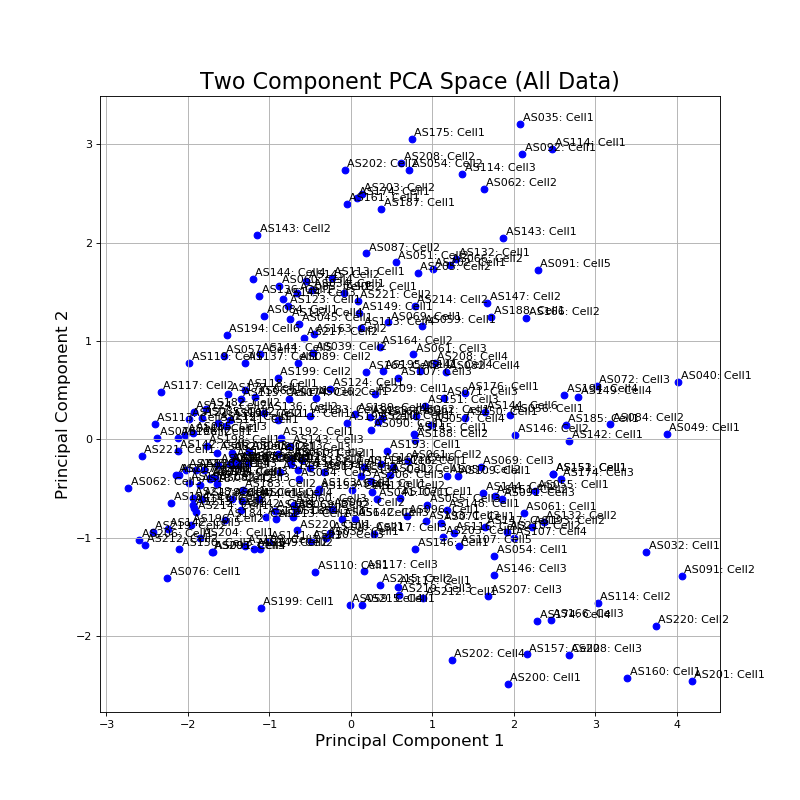

In [48]:
# Create plot of PC space (components 1/2)
P1 = PCA_components[0]
P2 = PCA_components[1]
labels = celllabels


fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(P1,P2, color='blue')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two Component PCA Space (All Data)', fontsize = 20)
ax.grid()

for i,type in enumerate(labels):
    
    x = P1[i]
    y = P2[i]
    plt.text(x+0.03, y+0.03, type, fontsize=10)
    
    
plt.show()

pcaDf=pd.DataFrame([P1,P2])
pcaDf.to_csv('E:\Jake\ephys_PCA_temp.csv')

<IPython.core.display.Javascript object>


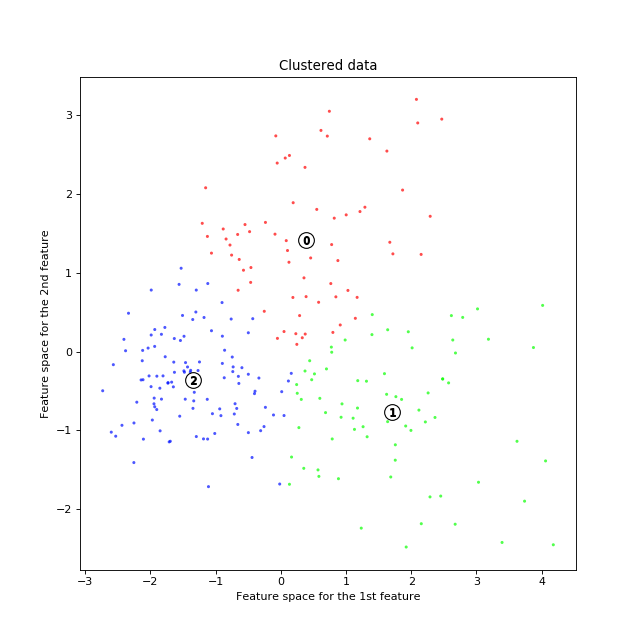

Text(0, 0.5, 'Feature space for the 2nd feature')

In [49]:
#K means clustering, n_clusters = 3
P1 = np.array(X_pca[:,0])
P2 = np.array(X_pca[:,1])


X = np.column_stack((P1,P2))

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8, 8)


clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(X)

colors = cm.hsv(cluster_labels.astype(float) / 3)
ax1.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

centers = clusterer.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_title("Clustered data")
ax1.set_xlabel("Feature space for the 1st feature")
ax1.set_ylabel("Feature space for the 2nd feature")

In [50]:
#Rename cells to fit my convention
cellNames=np.array(df.iloc[0, 1:252])
cellNames= [i.replace('Cell1','Cell01') for i in cellNames]
cellNames= [i.replace('Cell2','Cell02') for i in cellNames]
cellNames= [i.replace('Cell3','Cell03') for i in cellNames]
cellNames= [i.replace('Cell4','Cell04') for i in cellNames]

#Dataframe of ephys clusters by cell
clusterframe= pd.DataFrame(clusterer.labels_, index = cellNames, columns=['EPhys Cluster'])
clusterframe=clusterframe.rename_axis('CellID').T
clusterframe

CellID,AS031: Cell01,AS032: Cell01,AS034: Cell01,AS035: Cell01,AS036: Cell01,AS039: Cell01,AS039: Cell02,AS040: Cell01,AS041: Cell01,AS045: Cell01,...,AS217: Cell02,AS217: Cell03,AS218: Cell01,AS219: Cell01,AS219: Cell02,AS219: Cell03,AS220: Cell01,AS220: Cell02,AS221: Cell01,AS221: Cell02
EPhys Cluster,1,1,0,0,2,2,0,1,1,0,...,0,1,2,2,2,1,2,1,2,0


In [51]:
#Produces a dataframe of ephys clusters for n_clusters=3. A value of -1 means there is no ephys data for that cell
clusterframe1=pd.concat([clusterframe.T,  data], axis=1, join='inner')
clusterframe1=pd.DataFrame(clusterframe1.iloc[:,0])

ephyscellclusters=pd.DataFrame([-1]*len(data.index),index=data.index, columns=['Default Cluster'])

ephysClusters=pd.merge(clusterframe1, ephyscellclusters, left_index=True, right_index=True, how= 'right')
ephysClusters=pd.DataFrame(ephysClusters.agg(max,axis=1),columns=['EPhys Cluster'])
ephysClusters


,EPhys Cluster
Cell,
AS016: Cell01,-1.0
AS016: Cell02,-1.0
AS029: Cell01,-1.0
AS030: Cell01,-1.0
AS036: Cell01,2.0
AS038: Cell01,-1.0
AS039: Cell01,2.0
AS039: Cell02,0.0
AS040: Cell01,1.0


In [52]:
ephysClusters['PC1']=P1morph.values
ephysClusters['PC2']=P2morph.values
ephysClusters

,EPhys Cluster,PC1,PC2
Cell,,,
AS016: Cell01,-1.0,-0.608036,0.029409
AS016: Cell02,-1.0,-0.220089,-0.137859
AS029: Cell01,-1.0,0.448345,-0.085160
AS030: Cell01,-1.0,-0.586824,-0.014483
AS036: Cell01,2.0,-0.448357,0.101271
AS038: Cell01,-1.0,-0.289224,0.045995
AS039: Cell01,2.0,-0.606618,0.023049
AS039: Cell02,0.0,0.655984,-0.478008
AS040: Cell01,1.0,1.066604,-0.473631


<IPython.core.display.Javascript object>


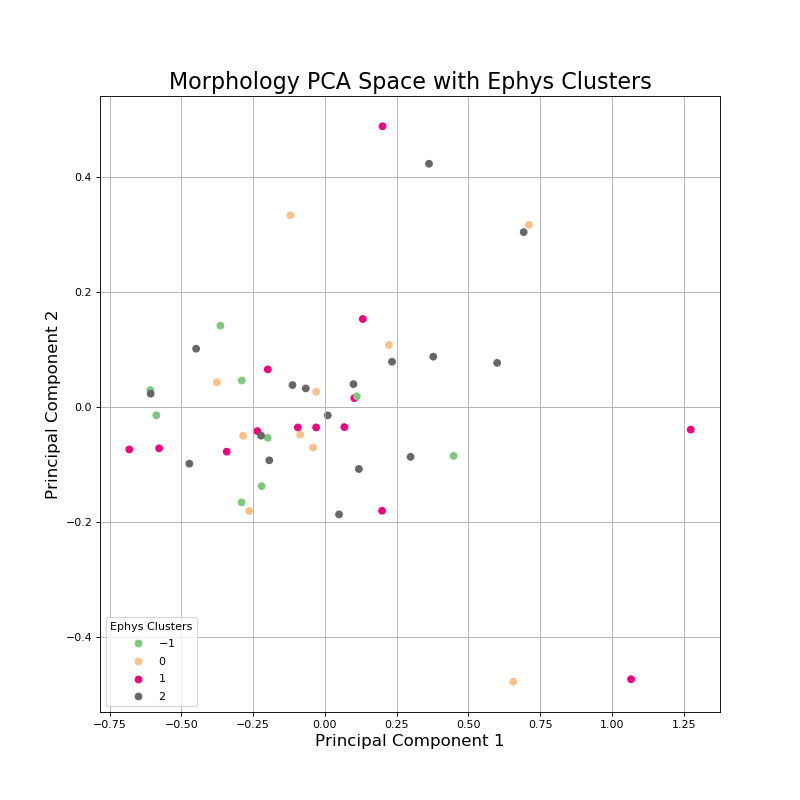

In [53]:
# Create plot of PC space (components 1/2)
import matplotlib.colors
import matplotlib.artist
import matplotlib.patches as patch
import matplotlib.cm

P1morph = ephysClusters['PC1']
P2morph = ephysClusters['PC2']
labs=[]
for i in range(0,len(data.index)):
    labs.append(data.index[i]+' '+str(df_all.iloc[0,i]))
labels = labs

colors=ephysClusters['EPhys Cluster']

fig, ax = plt.subplots(figsize=(10,10))
plot=plt.scatter(P1morph,P2morph, c=colors, cmap='Accent')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Morphology PCA Space with Ephys Clusters', fontsize = 20)
ax.grid()

legend1=ax.legend(*plot.legend_elements(),
                    loc="lower left", title="Ephys Clusters")

# ax.add_artist(legend1)
# for i,type in enumerate(labels):
    
#     x = P1[i]
#     y = P2[i]
#     plt.text(x+0.003, y+0.003, type, fontsize=9)
    
    
plt.show()